In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import nn_l2_mean
slim = tf.contrib.slim
ds = tf.contrib.distributions
# from universal_divergence import estimate

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.reset_default_graph()


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [5]:
params = dict(
    batch_size=512,
    learning_rate_1=1e-3,
    learning_rate_2=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=500,
    z_dim=256,
    x_dim=2,
    optimizer='panayo', # rmsprop sgd sga
    reg_w=10.
)

## Function for Symplectic gradient adjustment

## Construct model and training ops

In [6]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    print('sgd')
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(g_train_op, d_train_op)
    
elif params['optimizer'] == 'panayo':


#     copy_ops = [wprim.assign(w) for wprim,w in zip(varcopy,variables)]
#     restore_ops = [w.assign(wprim) for wprim,w in zip(varcopy,variables)]
    
    print('panayo')    
#     optimizer1 = tf.train.RMSPropOptimizer(1e-2, use_locking=True)
#     optimizer2 = tf.train.RMSPropOptimizer(1e-3, use_locking=True)

#     d_grads_c = tf.gradients(loss, disc_vars)
#     g_grads_c = tf.gradients(-loss, gen_vars)
#     grads_c = d_grads_c + g_grads_c
    
#     apply_vec_1 = [(g, v)for (g, v) in zip(grads, variables)]
    
#     apply_vec_2 = [(g, v)for (g, v) in zip(grads, varcopy)]
    
#     with tf.control_dependencies(copy_ops):
#         train_op1 = optimizer1.apply_gradients(apply_vec_1)
    
#     with tf.control_dependencies([train_op1]):
#         train_op2 = optimizer2.apply_gradients(apply_vec_2)
        
#     train_op = train_op2

    variables = disc_vars + gen_vars

    disc_vars_copy = [tf.Variable(var.initialized_value()) for var in disc_vars]
    gen_vars_copy = [tf.Variable(var.initialized_value()) for var in gen_vars]
    variables_copy = disc_vars_copy + gen_vars_copy

    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    grads = d_grads + g_grads
    
    varcopy_updates = []
    var_updates = []
    for grad, varcopy, var in zip(grads, variables_copy, variables):
        varcopy_updates.append(varcopy.assign(var))
        var_updates.append(var.assign(var - params['learning_rate_1'] * grad))
    update = varcopy_updates + var_updates
    train_op_inter = tf.group(*update)
    
    var_updates = []
    for grad, varcopy, var in zip(grads, variables_copy, variables):
        var_updates.append(var.assign(varcopy - params['learning_rate_2'] * grad))
    
    with tf.control_dependencies([train_op_inter]):
        train_op = tf.group(*var_updates)


panayo


## Train

In [7]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

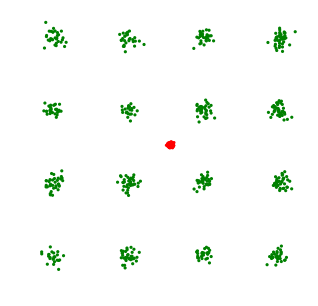

  2%|▏         | 500/20001 [00:09<06:00, 54.07it/s]

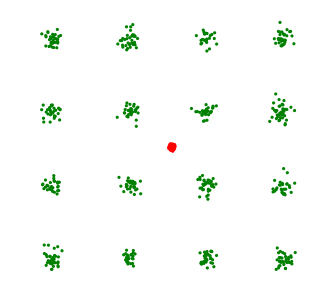

  5%|▍         | 1000/20001 [00:15<05:01, 63.10it/s]

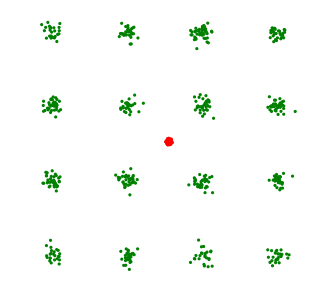

  7%|▋         | 1496/20001 [00:23<04:47, 64.26it/s]

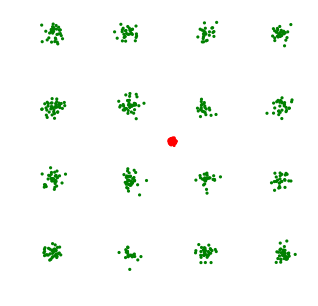

 10%|▉         | 1999/20001 [00:30<04:33, 65.72it/s]

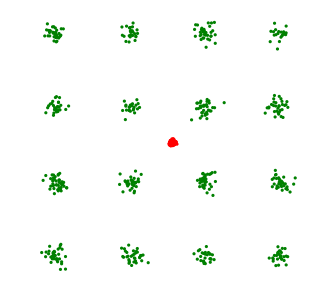

 12%|█▏        | 2495/20001 [00:37<04:25, 65.96it/s]

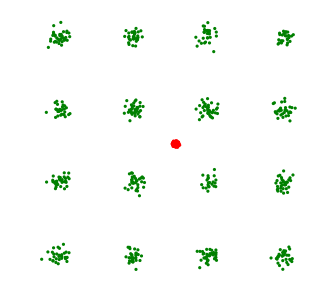

 15%|█▍        | 2994/20001 [00:45<04:17, 66.12it/s]

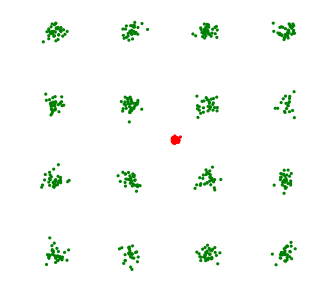

 17%|█▋        | 3494/20001 [00:53<04:10, 65.82it/s]

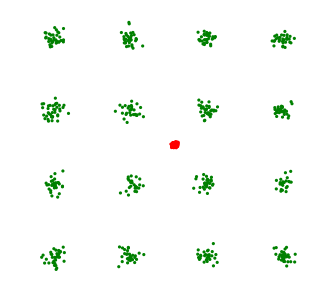

 20%|█▉        | 4000/20001 [01:00<04:01, 66.16it/s]

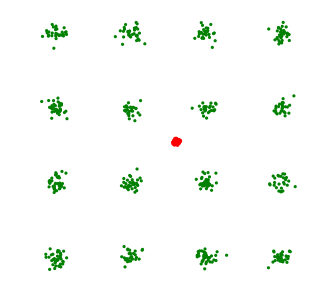

 22%|██▏       | 4499/20001 [01:07<03:52, 66.64it/s]

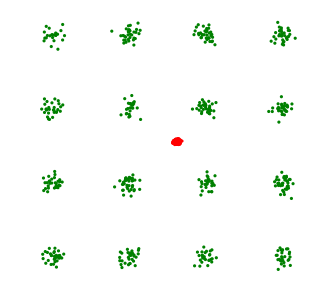

 25%|██▍       | 4996/20001 [01:14<03:44, 66.81it/s]

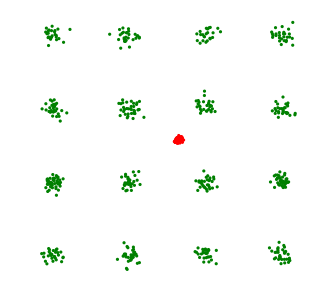

 27%|██▋       | 5496/20001 [01:21<03:35, 67.23it/s]

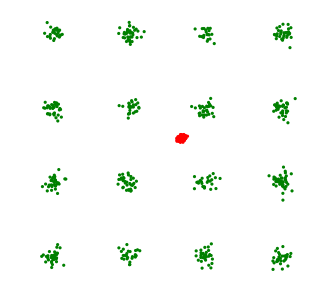

 30%|██▉       | 5996/20001 [01:28<03:27, 67.52it/s]

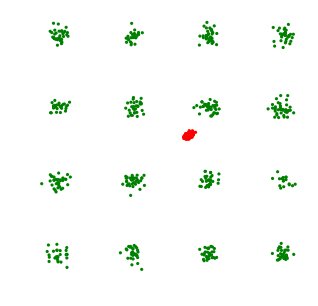

 32%|███▏      | 6498/20001 [01:36<03:19, 67.64it/s]

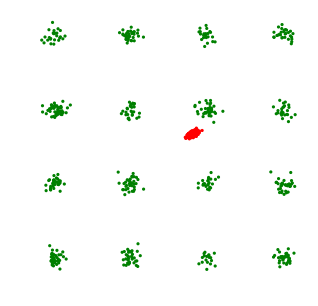

 35%|███▍      | 6993/20001 [01:43<03:12, 67.68it/s]

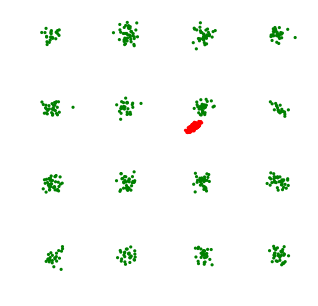

 37%|███▋      | 7498/20001 [01:51<03:05, 67.47it/s]

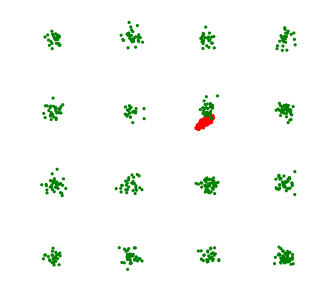

 40%|███▉      | 7995/20001 [01:57<02:57, 67.80it/s]

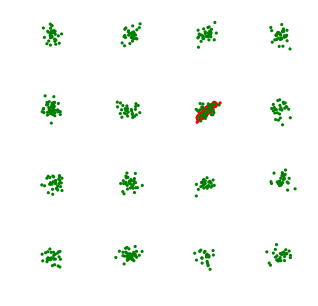

 42%|████▏     | 8494/20001 [02:05<02:50, 67.66it/s]

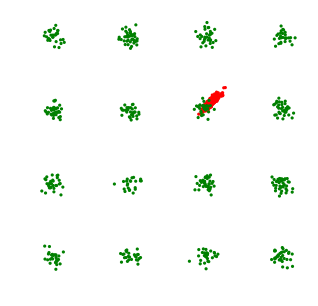

 45%|████▍     | 8999/20001 [02:13<02:42, 67.63it/s]

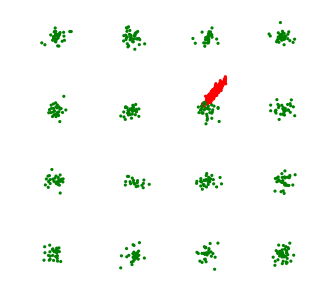

 47%|████▋     | 9500/20001 [02:19<02:34, 67.86it/s]

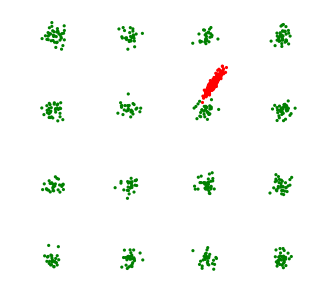

 50%|████▉     | 9992/20001 [02:26<02:27, 68.03it/s]

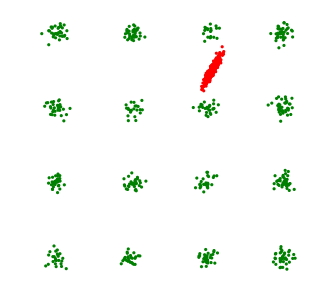

 52%|█████▏    | 10497/20001 [02:33<02:19, 68.23it/s]

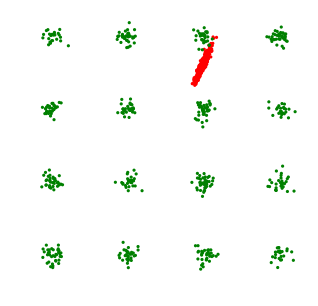

 55%|█████▍    | 10998/20001 [02:41<02:12, 68.00it/s]

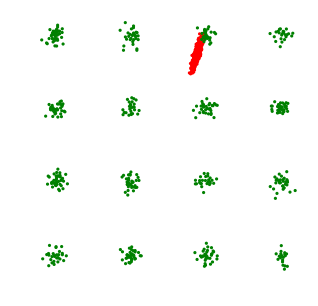

 57%|█████▋    | 11499/20001 [02:49<02:05, 67.98it/s]

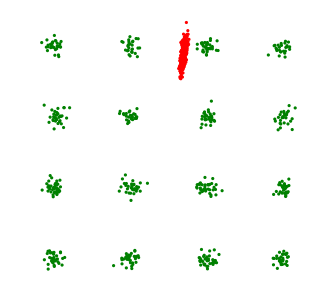

 60%|█████▉    | 12000/20001 [02:56<01:57, 68.13it/s]

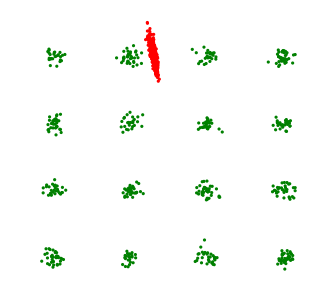

 62%|██████▏   | 12496/20001 [03:03<01:50, 68.15it/s]

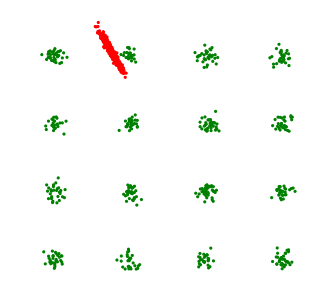

 65%|██████▍   | 12997/20001 [03:10<01:42, 68.27it/s]

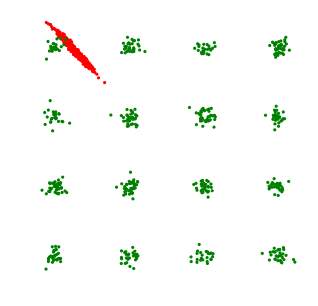

 67%|██████▋   | 13497/20001 [03:17<01:35, 68.24it/s]

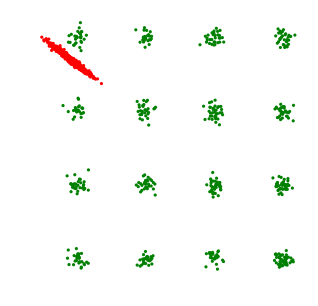

 70%|██████▉   | 13993/20001 [03:25<01:28, 68.00it/s]

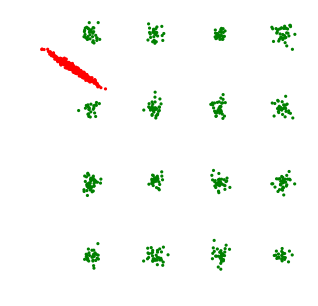

 72%|███████▏  | 14499/20001 [03:32<01:20, 68.17it/s]

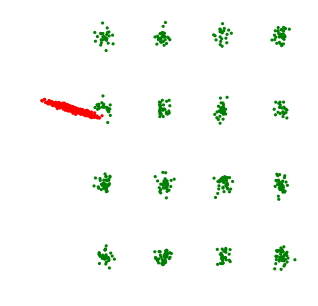

 75%|███████▍  | 14998/20001 [03:40<01:13, 68.16it/s]

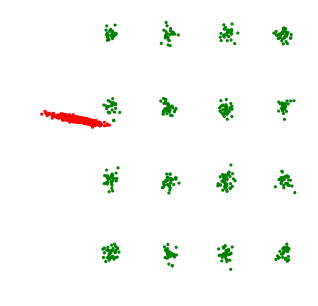

 77%|███████▋  | 15493/20001 [03:46<01:05, 68.32it/s]

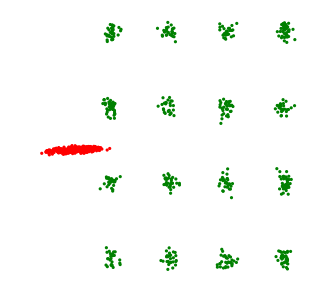

 80%|███████▉  | 16000/20001 [03:54<00:58, 68.32it/s]

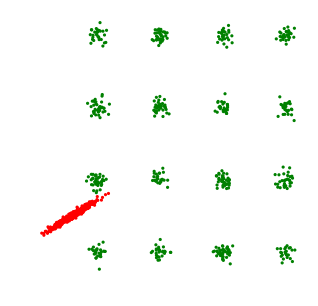

 82%|████████▏ | 16498/20001 [04:01<00:51, 68.28it/s]

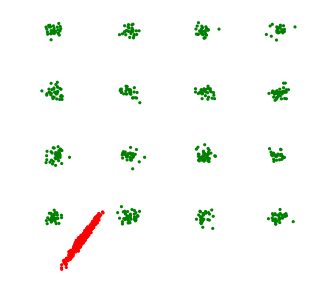

 85%|████████▍ | 16995/20001 [04:08<00:43, 68.40it/s]

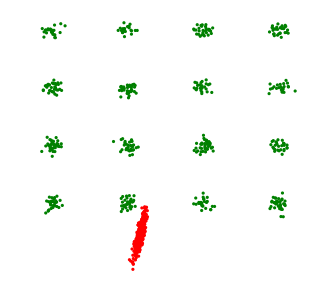

 87%|████████▋ | 17493/20001 [04:15<00:36, 68.59it/s]

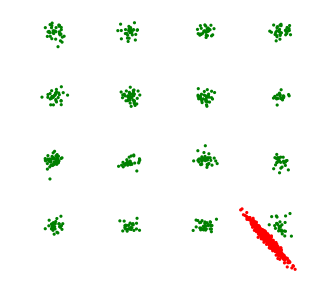

 90%|████████▉ | 17993/20001 [04:21<00:29, 68.69it/s]

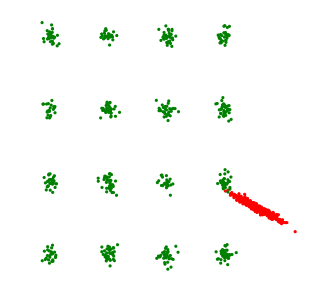

 92%|█████████▏| 18492/20001 [04:29<00:22, 68.54it/s]

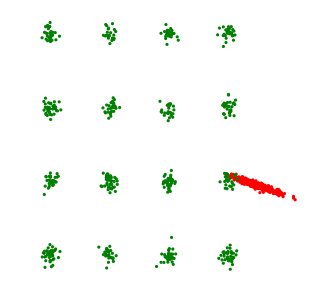

 95%|█████████▍| 18996/20001 [04:36<00:14, 68.63it/s]

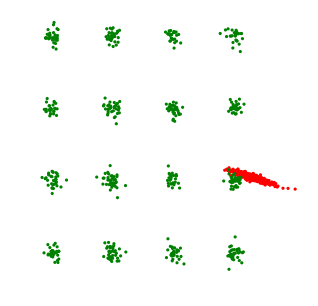

 97%|█████████▋| 19495/20001 [04:44<00:07, 68.63it/s]

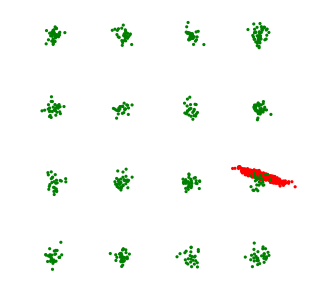

100%|█████████▉| 19998/20001 [04:51<00:00, 68.71it/s]

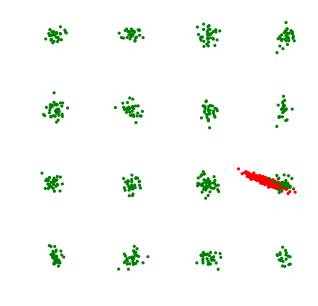

100%|██████████| 20001/20001 [04:51<00:00, 68.69it/s]


In [8]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
#     f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    f, _= sess.run([[loss], train_op])

    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], c='r',edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        axis('off')
        show()
        
#     if (i) % nn_every == 0:
#         x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
#         l2nn = nn_l2_mean(x,y_ref)
#         kl =estimate(x, y_ref,k=1)
#         nn_dist.append(l2nn)
#         nn_kl.append(kl)
#         print('dist = ', l2nn)
#         print('kl = ', kl)

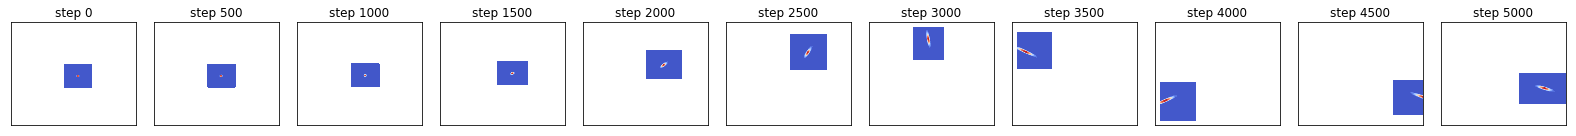

In [9]:
np_samples_ = np_samples[::4]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=20, clip=[[-6,6]]*2)

#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

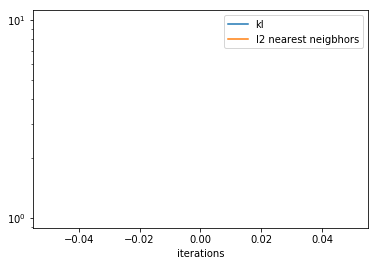

In [10]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [11]:
np.save('plot_con_kl',nn_kl)
np.save('plot_con_nn',nn_dist)